In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly.express as px
import os
import sys
import pyproj
sys.path.append("../src/if_license_plates_could_talk")
import data
import geo.utils
from shapely.geometry import LinearRing, shape
import geopy.distance

%matplotlib inline

In [2]:
df_geo = geo.utils.load_geodata()


In [3]:
germany = df_geo.dissolve()

<AxesSubplot:>

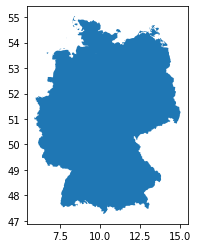

In [4]:
germany.plot()

In [7]:
def distance_to_border(df_geo, kreis_key):
    orig_crs = df_geo.crs
    buffered = germany.to_crs("+proj=cea").buffer(10000).to_crs(germany.crs)
    crs_vic = "epsg:32662"
    kreis_geom = df_geo[df_geo["RS"] == kreis_key]
    center_point = kreis_geom.to_crs(crs_vic).centroid
    center_point.reset_index(drop=True, inplace = True)
    border = buffered.boundary.to_crs(crs_vic).explode().iloc[0]
    border_shape = shape(border)
    
    pol_ext = LinearRing(border_shape.coords)
    d = pol_ext.project(center_point.geometry.loc[0])
    p = pol_ext.interpolate(d)

    cp_x, cp_y = center_point.geometry.loc[0].coords[0]

    closest = list(p.coords)[0]
    
    point_geometry =  gpd.points_from_xy(x = [cp_x, closest[0]], y = [cp_y, closest[1]])
    point_df = gpd.GeoDataFrame({}, geometry = point_geometry, crs = crs_vic).to_crs(orig_crs)

    return geopy.distance.geodesic(point_df.loc[0, "geometry"].coords[0], point_df.loc[1, "geometry"].coords[0]).kilometers

In [8]:
distance_to_border(df_geo, "04012")

30.17081803184046